In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt

In [2]:
# use float64
from jax.config import config
config.update("jax_enable_x64", True)

# use retina plots
%config InlineBackend.figure_format='retina'

Note: the entire notebook is based on [this article](https://thegradient.pub/gaussian-process-not-quite-for-dummies/) from *The Gradient*

# notation

![](https://user-images.githubusercontent.com/18204038/61701083-7b98e380-ad35-11e9-8012-5b86e1299cf5.png)
![](https://user-images.githubusercontent.com/18204038/61703635-ea783b80-ad39-11e9-9606-54b5995df95c.png)

# helper functions

In [3]:
def sample_mv_normal(key, mean, cov, shape, epsilon=1e-8):
    """
    like jax.random.multivariate_normal but with better numerical stability (thanks to epsilon)
    when sampling from a multivariate normal, we have to perform cholesky decomposition of the covariance matrix
    note: the RBF kernel is positive definite (?) 
    to avoid numerical problems with the decomposition, it helps to add epsilon * identity matrix
    based on: https://stats.stackexchange.com/a/386837/231402
    """
    n = len(mean)
    z = jax.random.multivariate_normal(key, jnp.zeros(n), jnp.eye(n), shape=shape)
    A = jnp.linalg.cholesky(cov + epsilon*jnp.eye(n))
    y = vmap(lambda z: A @ z + mean)(z) 
    return y

# define kernel function

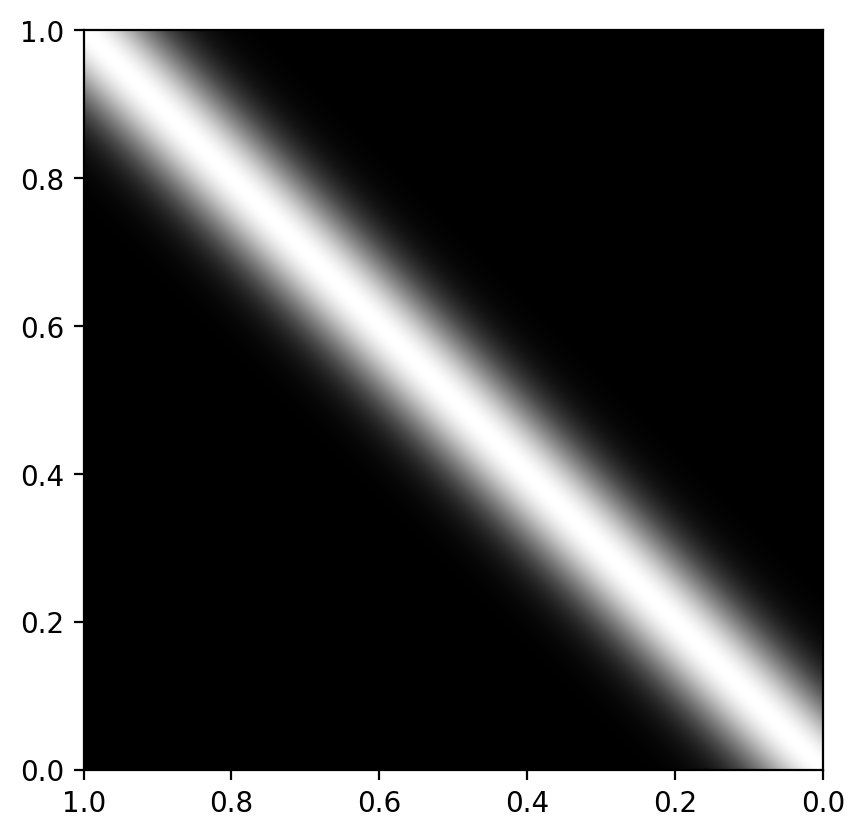

1.739959106031437e-45 0.36


In [4]:
# define kernel function
# note: currently only implemented for 1D
vertical_scale = 0.6
horizontal_scale = 0.07
def kernel_fn(x1, x2):
    """
    x1.shape = [n1]
    x2.shape = [n2]
    out.shape = [n1 x n2]
    """
    return vertical_scale**2 * jnp.exp(- 0.5 * (x1[:, None] - x2[None, :])**2 / horizontal_scale**2)

# plot kernel function
n_samples = 1_000
x1 = jnp.linspace(0, 1, n_samples)
x2 = jnp.linspace(0, 1, n_samples)
K = kernel_fn(x1, x2)
plt.imshow(K, cmap='gray', extent=[1, 0, 0, 1])
plt.show()
print(K.min(), K.max())

# plots

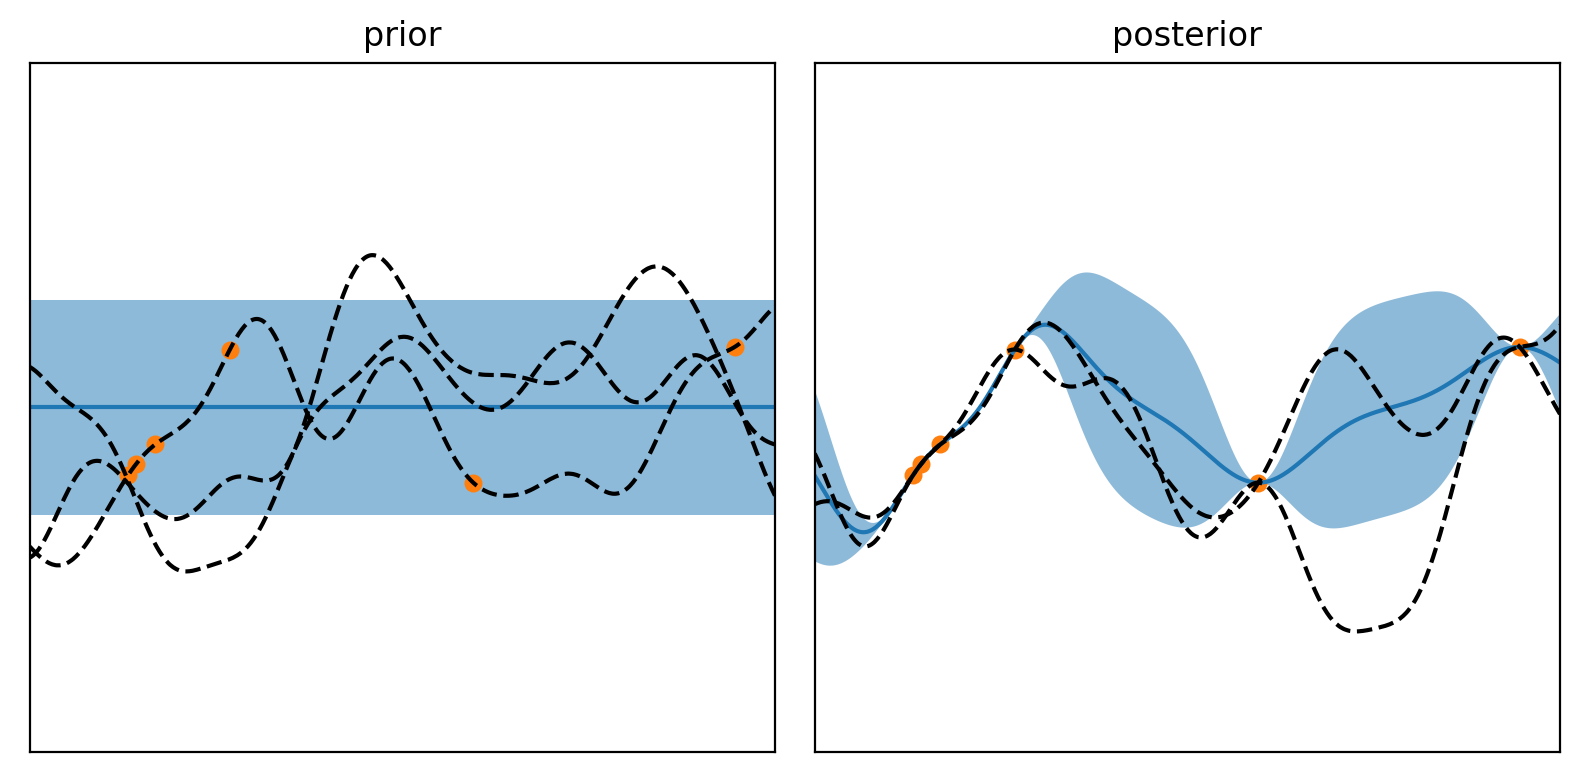

In [5]:
fig, axs = plt.subplots(1, 2, figsize=[8, 4])
axs[0].set_title("prior")
axs[1].set_title("posterior")

# plot prior
n_plot = 500
x1 = jnp.linspace(0, 1, n_plot)
mean = jnp.zeros_like(x1)
cov = kernel_fn(x1, x1)
sd = cov.diagonal()
axs[0].plot(x1, mean)
axs[0].fill_between(x1, mean-2*sd, mean+2*sd, alpha=0.5)

# plot samples from prior
n_samples = 3
key = jax.random.PRNGKey(0)
samples = sample_mv_normal(key, mean, cov, [n_samples])
for y1 in samples:
    axs[0].plot(x1, y1, c='black', ls='--')
    
# use one of the sampled draws to generate observations
n_train = 6
key = jax.random.PRNGKey(0)
x1_idx = jax.random.choice(key, n_plot, shape=[n_train], replace=False)
x2 = x1[x1_idx]
y2 = samples[0][x1_idx]

# condition on observations
A = kernel_fn(x1, x1)
B = kernel_fn(x1, x2)
C = kernel_fn(x2, x2)
mean = B @ jnp.linalg.lstsq(C, y2)[0]
cov = A - B @ jnp.linalg.lstsq(C, B.T)[0]
sd = cov.diagonal()

# plot posterior
axs[1].plot(x1, mean)
axs[1].fill_between(x1, mean-2*sd, mean+2*sd, alpha=0.5)

# plot samples from posterior
n_samples = 2
key = jax.random.PRNGKey(0)
samples = sample_mv_normal(key, mean, cov, [n_samples])
for y1 in samples:
    axs[1].plot(x1, y1, c='black', ls='--')

# shared
for ax in axs:
    ax.set_xlim([0, 1])
    ax.set_ylim([-2.3, 2.3])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(x2, y2, s=30)

plt.tight_layout()
plt.show()